In [153]:
# uni_D83AE5_uni (Baseline)
#   {"Logloss": 0.024805154294331146, "ROCAUC": 0.9811772452514946}
#   {"Logloss": 0.02470931219446125, "ROCAUC": 0.9810926019123885}
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import gamma, kstest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    log_loss, 
    roc_auc_score, 
    roc_curve, 
    auc
)
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')  # Use this line to suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

training_data = pd.read_csv('training_data.csv')
training_data = training_data[training_data['BORROWER_ID'] != 'xNullx']
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True)
data_submission_example = pd.read_csv('data_submission_example.csv')

lognormal_variables = [
    'CONTRACT_CREDIT_LOSS', 'CONTRACT_DEPT_SERVICE_TO_INCOME',
    'CONTRACT_INCOME', 'CONTRACT_INSTALMENT_AMOUNT', 'CONTRACT_INSTALMENT_AMOUNT_2',
    'CONTRACT_LOAN_AMOUNT', 'CONTRACT_MARKET_VALUE', 'CONTRACT_MORTGAGE_LENDING_VALUE', 
    'CONTRACT_LGD', 'CONTRACT_INCOME'
]

In [154]:
# # ADDITION 1
# import pandas as pd
# import numpy as np
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()
# excluded_keywords = ['TARGET', 'event', 'binary', 'DATE', 'DAYS', 'YEARS', 'MATURITY', 'DAY', 'BORROWER']

# X_columns = [col for col in numeric_columns if all(keyword.lower() not in col.lower() for keyword in excluded_keywords)]
# X_columns.remove('CONTRACT_TYPE_OF_INTEREST_REPAYMENT')
# X_columns.remove('CONTRACT_MORTGAGE_TYPE')
# df_copy = training_data.copy()
# print(df_copy.isna().sum().sum())
# min_values = []
# for i in X_columns:
#     if i in lognormal_variables:
#         min_values.append(1)
#     else:
#         min_values.append(-np.inf)
# imputer = IterativeImputer(max_iter=30, random_state=42, min_value=min_values,)
# imputed_values = imputer.fit_transform(df_copy[X_columns])

In [155]:
# # ADDITION 2
# imputed_df = pd.DataFrame(imputed_values, columns=X_columns)

# for col in X_columns:
#     if imputed_df[col].dtype == 'float64':
#         imputed_df[col] = imputed_df[col].astype('float32')
#     elif imputed_df[col].dtype == 'int64':
#         imputed_df[col] = imputed_df[col].astype('int32')

# training_data.update(imputed_df)

In [156]:
training_data.fillna(0, inplace=True)
for col in training_data.columns:
    try:
        training_data[col] = pd.to_numeric(training_data[col], errors='ignore')
    except:
        continue
training_data['TARGET_EVENT_BINARY'] = np.where(training_data['TARGET_EVENT'] == 'K', 1, 0)

In [157]:
training_data.isna().sum()

CONTRACT_ID                            0
BORROWER_ID                            0
CONTRACT_BANK_ID                       0
CONTRACT_CREDIT_INTERMEDIARY           0
CONTRACT_CREDIT_LOSS                   0
CONTRACT_CURRENCY                      0
CONTRACT_DATE_OF_LOAN_AGREEMENT        0
CONTRACT_DEPT_SERVICE_TO_INCOME        0
CONTRACT_FREQUENCY_TYPE                0
CONTRACT_INCOME                        0
CONTRACT_INSTALMENT_AMOUNT             0
CONTRACT_INSTALMENT_AMOUNT_2           0
CONTRACT_INTEREST_PERIOD               0
CONTRACT_INTEREST_RATE                 0
CONTRACT_LGD                           0
CONTRACT_LOAN_AMOUNT                   0
CONTRACT_LOAN_CONTRACT_TYPE            0
CONTRACT_LOAN_TO_VALUE_RATIO           0
CONTRACT_LOAN_TYPE                     0
CONTRACT_MARKET_VALUE                  0
CONTRACT_MATURITY_DATE                 0
CONTRACT_MORTGAGE_LENDING_VALUE        0
CONTRACT_MORTGAGE_TYPE                 0
CONTRACT_REFINANCED                    0
CONTRACT_RISK_WE

In [158]:
training_data['TARGET_EVENT_E'] = np.where(training_data['TARGET_EVENT'] == 'E', 1, 0)

In [159]:
training_data['TARGET_EVENT_BINARY'].value_counts()

TARGET_EVENT_BINARY
0    1590792
1      10871
Name: count, dtype: int64

In [160]:

date_variables = ['CONTRACT_DATE_OF_LOAN_AGREEMENT', 'CONTRACT_MATURITY_DATE']

In [161]:
training_data['TARGET_EVENT_DAY'].replace(0.0, np.nan, inplace=True)
training_data['TARGET_EVENT_DAY_JULIAN'] = pd.to_datetime(training_data['TARGET_EVENT_DAY'], origin='julian', unit='D', errors='coerce')
training_data['TARGET_EVENT_DAY_DATETIME'] = pd.to_datetime(training_data['TARGET_EVENT_DAY_JULIAN'],  errors='coerce')

training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'], origin='julian', unit='D')
training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'],)

training_data['CONTRACT_MATURITY_DATE_JULIAN'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE'], origin='julian', unit='D')
training_data['CONTRACT_MATURITY_DATE_DATETIME'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE_JULIAN'])

In [162]:
training_data['DAY_DIFF'] = (training_data['TARGET_EVENT_DAY_DATETIME'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['DAYS_TO_END'] = (pd.Timestamp("2020-01-01")- training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['YEARS_TO_END'] = training_data['DAYS_TO_END'] / 365
training_data['DAYS_TO_2018'] = (pd.Timestamp("2018-01-01")- training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['YEARS_TO_2018'] = training_data['DAYS_TO_2018'] / 365
training_data['TIME_TO_MATURITY_DAYS'] = (training_data['CONTRACT_MATURITY_DATE']-training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'])
training_data['2020_OR_MATURITY'] = np.minimum(training_data['TIME_TO_MATURITY_DAYS'], training_data['DAYS_TO_END'])
training_data['2020_OR_MATURITY_YEARS'] = training_data['2020_OR_MATURITY'] / 365

In [163]:
def create_binary_target_column(dataframe, column_name, event, day_diff_upper_limit):
    dataframe[column_name] = np.where(
        (dataframe['TARGET_EVENT'] == event) & 
        (dataframe['DAY_DIFF'] <= day_diff_upper_limit) & 
        (dataframe['DAY_DIFF'] >= 0), 
        1, 
        0
    )

timeframes = {
    'TARGET_EVENT_BINARY_2Y': 730,
    'TARGET_EVENT_BINARY_1Y': 365,
    'TARGET_EVENT_BINARY_6M': 365//2,
}

for column_name, days in timeframes.items():
    create_binary_target_column(training_data, column_name, 'K', days)


# target_event_binary_columns = []
# for i in range(6):
#     start_day = 273 + i * 30
#     column_header = 'TARGET_EVENT_BINARY_' + str(start_day) + 'D'
#     training_data[column_header] = np.where(
#         (training_data['TARGET_EVENT'] == 'K') & 
#         (training_data['DAY_DIFF'] <= start_day) & 
#         (training_data['DAY_DIFF'] >= 0), 
#         1, 
#         0
#     )
#     target_event_binary_columns.append(column_header)

training_data.drop('DAY_DIFF', axis=1, inplace=True)

In [164]:
print(training_data['TARGET_EVENT_BINARY'].value_counts())
print(training_data['TARGET_EVENT_BINARY_2Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_1Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_6M'].value_counts())

TARGET_EVENT_BINARY
0    1590792
1      10871
Name: count, dtype: int64
TARGET_EVENT_BINARY_2Y
0    1591751
1       9912
Name: count, dtype: int64
TARGET_EVENT_BINARY_1Y
0    1596927
1       4736
Name: count, dtype: int64
TARGET_EVENT_BINARY_6M
0    1601267
1        396
Name: count, dtype: int64


In [165]:
numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()
excluded_keywords = ['TARGET', 'event', 'binary', 'DATE', 'DAYS', 'YEARS', 'MATURITY', 'DAY']

X_columns = [col for col in numeric_columns if all(keyword.lower() not in col.lower() for keyword in excluded_keywords)]
y_column = 'TARGET_EVENT_BINARY_2Y' 
X_columns

['CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_CREDIT_LOSS',
 'CONTRACT_CURRENCY',
 'CONTRACT_DEPT_SERVICE_TO_INCOME',
 'CONTRACT_INCOME',
 'CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_INSTALMENT_AMOUNT_2',
 'CONTRACT_INTEREST_PERIOD',
 'CONTRACT_INTEREST_RATE',
 'CONTRACT_LGD',
 'CONTRACT_LOAN_AMOUNT',
 'CONTRACT_LOAN_CONTRACT_TYPE',
 'CONTRACT_LOAN_TO_VALUE_RATIO',
 'CONTRACT_MARKET_VALUE',
 'CONTRACT_MORTGAGE_LENDING_VALUE',
 'CONTRACT_MORTGAGE_TYPE',
 'CONTRACT_REFINANCED',
 'CONTRACT_RISK_WEIGHTED_ASSETS',
 'CONTRACT_TYPE_OF_INTEREST_REPAYMENT',
 'BORROWER_BIRTH_YEAR',
 'BORROWER_CITIZENSHIP',
 'BORROWER_COUNTRY',
 'BORROWER_COUNTY',
 'BORROWER_TYPE_OF_SETTLEMENT']

In [166]:
import numpy as np
import numpy_financial as npf
import pandas as pd

def calculate_monthly_payment(row):
    annual_interest_rate = row['CONTRACT_INTEREST_RATE'] / 100  # Convert percentage to decimal
    monthly_interest_rate = annual_interest_rate / 12
    term_in_months = ((pd.to_datetime(row['CONTRACT_MATURITY_DATE_DATETIME'], format='%d/%m/%Y') - 
                       pd.to_datetime(row['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'], format='%d/%m/%Y'))).days/30
    principal = row['CONTRACT_LOAN_AMOUNT']
    monthly_payment = npf.pmt(monthly_interest_rate, term_in_months, -principal)
    return monthly_payment
# ADDITION 3:

# X_columns.append('TIME_TO_MATURITY_DAYS')

In [167]:
loan_type_dummies = pd.get_dummies(training_data['CONTRACT_LOAN_TYPE'], prefix='LOAN_TYPE', drop_first=True)
frequency_type_dummies = pd.get_dummies(training_data['CONTRACT_FREQUENCY_TYPE'], prefix='FREQ_TYPE', drop_first=True)
interest_type_dummies = pd.get_dummies(training_data['CONTRACT_TYPE_OF_INTEREST_REPAYMENT'], prefix='INTEREST_TYPE', drop_first=True)
mortgage_type_dummies =  pd.get_dummies(training_data['CONTRACT_MORTGAGE_TYPE'], prefix='MORTGAGE_TYPE', drop_first=True)

training_data = pd.concat([training_data, loan_type_dummies, frequency_type_dummies,interest_type_dummies,mortgage_type_dummies ], axis=1)

X_columns.extend(loan_type_dummies.columns)
X_columns.extend(frequency_type_dummies.columns)
X_columns.extend(interest_type_dummies.columns)
X_columns.extend(mortgage_type_dummies.columns)
# X_columns.remove('CONTRACT_LOAN_TYPE')
# X_columns.remove('CONTRACT_FREQUENCY_TYPE')
X_columns.remove('CONTRACT_TYPE_OF_INTEREST_REPAYMENT')
X_columns.remove('CONTRACT_MORTGAGE_TYPE')

In [168]:
# training_data.loc[training_data['BORROWER_CITIZENSHIP'] == 0, 'BORROWER_CITIZENSHIP'] = 98
# citizenship_type_dummies = pd.get_dummies(training_data['BORROWER_CITIZENSHIP'], prefix='CITIZENSHIP_TYPE', drop_first=True)
# training_data = pd.concat([training_data, citizenship_type_dummies ], axis=1)
# X_columns.extend(citizenship_type_dummies.columns)

In [169]:
training_data['BORROWER_LOAN_COUNT'] = training_data.groupby('BORROWER_ID')['BORROWER_ID'].transform('count')
training_data['LOAN_BORROWER_COUNT'] = training_data.groupby('CONTRACT_ID')['CONTRACT_ID'].transform('count')
training_data['TOTAL_LOAN_AMOUNT'] = training_data.groupby('BORROWER_ID')['CONTRACT_LOAN_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_1'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_2'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT_2'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT'] = training_data['TOTAL_INSTALLMENT_AMOUNT_1'] + training_data['TOTAL_INSTALLMENT_AMOUNT_2']

X_columns.extend(['BORROWER_LOAN_COUNT', 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT','LOAN_BORROWER_COUNT'])
lognormal_variables.extend([ 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT'])

In [170]:
threshold = 0.85
correlation_matrix = training_data[X_columns].corr()
highly_correlated_set = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_set.add(colname)

X_columns = [col for col in X_columns if col not in highly_correlated_set]
print('Variables removed:', highly_correlated_set)

Variables removed: {'BORROWER_COUNTRY', 'CONTRACT_REFINANCED', 'FREQ_TYPE_2f88e16c'}


In [171]:
def default_percentage_generator_2016(df, percentage, target, random_sample=42):
    df_copy = df.copy()
    df_filtered = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    df_mean = df_filtered[target].mean()
    print(f"Mean in year {df_mean}")
    df_defautled = df_filtered[target].sum()
    df_not_defaulted = len(df_filtered) - df_defautled

    required_val = (df_defautled - percentage * len(df_filtered))/(percentage - 1)
    
    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==1] 
    print(len(df_filtered_after))
    print(required_val)
    required_val = min(int(required_val) ,len(df_filtered_after))
    df_filtered_after = df_filtered_after.sample(n=int(required_val),random_state=random_sample).reset_index(drop=True)

    df_filtered = pd.concat([df_filtered, df_filtered_after])

    return df_filtered

def default_percentage_generator_2016_maximal(df, percentage, target):
    df_copy = df.copy()

    defaulted = df_copy[(df_copy[target]==1) & (df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2018-01-01')]
    total_needed = len(defaulted) / percentage * 100 - len(defaulted)


    # print(len(defaulted))
    # print(total_needed)

    df_filtered_2016 = df_copy[(df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01')& (df_copy[target]==0)]
    # print(len(df_filtered_2016))
    # print(total_needed)
    max_needed = min(total_needed,len(df_filtered_2016))
    df_filtered_2016 = df_filtered_2016.sample(n=int(max_needed),random_state=42).reset_index(drop=True)

    extra_needed = total_needed - len(df_filtered_2016)

    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==0]
    df_filtered_after = df_filtered_after.sample(n=int(extra_needed),random_state=42).reset_index(drop=True)


    df_filtered = pd.concat([df_filtered_2016, df_filtered_after,defaulted])

    return df_filtered

# default_percentage_generator_2016_maximal(training_data, 1.48, 'TARGET_EVENT_BINARY')['TARGET_EVENT_BINARY'].mean()


In [172]:
def calculate_probabilities(data, column, time_factor):
    lambdas = -np.log(1 - data[column]) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y
def calculate_probabilities_vec(data, time_factor):
    lambdas = -np.log(1 - data) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y


In [201]:
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


def train_and_predict_two_halves(df, variables, target, model=LogisticRegression(), 
                                 scaler=StandardScaler(), augment_distribution=True,calibrate=True,
                                 augment_distribution_percentage = 1.48, unique_loans=False,
                                 should_smote =False,maximal_sample=False,random_sample=42, 
                                 show_curve=False, calib_method = 'isotonic'):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    if augment_distribution and not maximal_sample:
        df_filtered = default_percentage_generator_2016(df, augment_distribution_percentage/100, target, random_sample)
    else:
        df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    
    if maximal_sample:
        df_filtered = default_percentage_generator_2016_maximal(df, augment_distribution_percentage, target)
        print(df_filtered[target].mean())

    if unique_loans:
        df_filtered = df_filtered.drop_duplicates(subset=['CONTRACT_ID'])

    
    X_scaled = scaler.fit_transform(df[variables])
    X_filtered = scaler.transform(df_filtered[variables])

    y = df[target] 
    y_filtered = df_filtered[target] 
    if should_smote:
        smote = SMOTE(random_state=42)
        X_filtered, y_filtered = smote.fit_resample(X_filtered, y_filtered)

    if calibrate:
        model = CalibratedClassifierCV(base_estimator=model, method=calib_method, )

    model.fit(X_filtered, y_filtered)
    

    print("Logloss:")
    test_proba = model.predict_proba(X_filtered)
    print(log_loss(y_filtered,test_proba))
    proba = model.predict_proba(X_scaled)[:, 1]
    # Additional code for ROC AUC score
    roc_auc = roc_auc_score(y_filtered,test_proba[:,1])
    print("ROC AUC Score:", roc_auc)
    if show_curve:
        true_probas, predicted_probas = calibration_curve(y_filtered, test_proba[:, 1], n_bins=10)

        # Plotting the calibration curve
        plt.figure(figsize=(8, 6))
        plt.plot(predicted_probas, true_probas, marker='o')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Calibration Curve')
        plt.show()

    return proba, model


In [174]:
def significant_features(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    if lognormal_variables is not None:
        df = df.copy()
        print(df[variables].isna().sum().sum())
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    print(np.isinf(df[variables]).sum().sum())
    X_scaled = scaler.fit_transform(df[variables])
    print(np.isinf(X_scaled).sum().sum())
    print(pd.DataFrame(X_scaled, columns=variables).isna().sum().sum())
    X = sm.add_constant(pd.DataFrame(X_scaled, columns=variables))
    y = df[target]
    model = sm.Logit(y, X).fit()
    print(model.summary())
    p_values = model.pvalues
    non_significant_vars = p_values[p_values > 0.05].index.tolist()

    return model, non_significant_vars

In [236]:
def combined_probability(s):
    if len(s) == 2:
        p_a, p_b = s.values
        return p_a + p_b - p_a * p_b #- (-3.2357827075016176e-05)
    else:
        return 1 - np.prod(1 - s.values)

def create_submission_file(df_preds, target, example, filename='submission.csv', testing=False):
    # Filter the data to only include BORROWER_IDs that are in the submission example
    df_preds.loc[df_preds['TARGET_EVENT'] == 'E', target] = 0

    print("Logloss:")
    print(log_loss(df_preds['TARGET_EVENT_BINARY'], df_preds[target]))

    filtered_training_data = df_preds[df_preds['BORROWER_ID'].isin(example['BORROWER_ID'])]

    # Print warning if the row count is off
    if not testing and len(filtered_training_data) != 1564601:
        print('WARNING: The filtered data does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
    # Group by BORROWER_ID and calculate the combined probability

    #######################x########################
    #CUTTING TAILS DID NOT SEEM TO WORK
    #######################x########################
    # filtered_training_data = cut_exponential_tails(filtered_training_data, target)
    grouped_data = filtered_training_data.groupby('BORROWER_ID')[target].apply(combined_probability).reset_index()

    # Create the submission DataFrame
    df_submission = pd.DataFrame()
    df_submission['BORROWER_ID'] = grouped_data['BORROWER_ID']
    df_submission['PRED'] = grouped_data[target]
    print('Before centering:')
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    print('Centering probabilities...')
    # Center the probabilities around 1.48%
    desired_mean = 0.0148  # 1.48% as a decimal
    # while (df_submission['PRED'].max() > 1 or df_submission['PRED'].min() < 0 or abs(df_submission['PRED'].mean() -0.0148) > 0.0005):
    #     # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    #     df_submission['PRED'] = df_submission['PRED'].clip(lower=0, upper=1)
    #     # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    #     current_mean = df_submission['PRED'].mean()
    #     adjustment_factor = desired_mean  - current_mean
    #     df_submission['PRED'] += adjustment_factor
    initial_guess = 2
    probas_unscaled = df_submission['PRED'].values
    new_proba = probas_unscaled.copy()
    while abs(new_proba.mean() - desired_mean) > 0.00001:
        
        new_proba = calculate_probabilities_vec(probas_unscaled, initial_guess)
        error = new_proba.mean() - desired_mean
        if error > 0:
            initial_guess += 0.001
        else:
            initial_guess -= 0.001
        print(error, initial_guess)
    df_submission['PRED'] = new_proba
        
        
    
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    # Save the submission file
    if  not testing and filename is not None:
        df_submission.to_csv(filename, index=False)
    print(f'Saved file: {filename}')
    # if abs(df_submission['PRED'].mean() -0.0148) > 0.0005:
    #    raise ValueError('WARNING: mean is bad')
        
    # Print warning if the row count is off
    if not testing and len(df_submission) != 1117674:
        print('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        
    return df_submission


In [176]:
def test_model_2y_1y(df, variables, target, model1=LogisticRegression(), model2=LogisticRegression()):
    df = df.copy()
    start_date = pd.Timestamp('2015-01-01')
    end_date = pd.Timestamp('2017-01-01')

    # Mask for rows with CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN between start_date and end_date
    mask_date_range = (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] >= start_date) & (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] <= end_date)

    df = df[mask_date_range]

    probs = train_and_predict_two_halves(
        df, 
        variables, 
        target, 
        model1=model1,
        model2=model2,
    )
    df['2Y-1Y-PROBS'] = probs
    
    test_data = pd.read_csv('./data/1y-test.csv')


    df_submission = create_submission_file(df, '2Y-1Y-PROBS', test_data, filename=None, testing=True)

    merged_df = pd.merge(test_data, df_submission, on='BORROWER_ID')
    true_labels = merged_df['TARGET_EVENT_BINARY_1Y']
    predicted_probs = merged_df['PRED']
    logloss = log_loss(true_labels, predicted_probs)

    print(f'Log loss: {logloss}')
        
    return logloss

In [177]:
def scale_yearly_proba(data, proba, targets =[ 0.0052, 0.0099, 0.0185], logging=False):
    data = data.copy()
    probs = data[proba]
    starter_scales=[2.8, 1.2, 0.75]
    new_proba = np.zeros(len(data))
    mask_2016 = (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01') & (data['TARGET_EVENT_BINARY'] != 1)
    mask_2017 = (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01') & (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01')& (data['TARGET_EVENT_BINARY'] != 1)
    mask_2018 = (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-01-01') & (data['TARGET_EVENT_BINARY'] != 1)

    proba_2016 = probs
    proba_2017 = probs
    proba_2018 = probs
    if logging:
        print("Before scaling:")
        print(proba_2016[mask_2016].mean(), proba_2017[mask_2017].mean(), proba_2018[mask_2018].mean())
        print(probs.mean())
    calib_2016 = True
    calib_2017 = True
    calib_2018 = True

    while calib_2016 or calib_2017 or calib_2018:    
        proba_2016 = probs
        proba_2017 = probs
        proba_2018 = probs
        proba_2016 = calculate_probabilities_vec(proba_2016, starter_scales[0])
        proba_2017 = calculate_probabilities_vec(proba_2017, starter_scales[1])
        proba_2018 = calculate_probabilities_vec(proba_2018, starter_scales[2])
        
        new_proba[mask_2016] = proba_2016[mask_2016]
        new_proba[mask_2017] = proba_2017[mask_2017]
        new_proba[mask_2018] = proba_2018[mask_2018]
        if logging:
            print('Adter scaling:')
            print(proba_2016[mask_2016].mean(), proba_2017[mask_2017].mean(), proba_2018[mask_2018].mean())
            print(new_proba.mean())

        mean_2016 = proba_2016[mask_2016].mean()
        mean_2017 = proba_2017[mask_2017].mean()
        mean_2018 = proba_2018[mask_2018].mean()

        diff_2016 = mean_2016 - targets[0]
        diff_2017 = mean_2017 - targets[1]
        diff_2018 = mean_2018 - targets[2]
        if diff_2016 > 0.0001:
            starter_scales[0] += 0.01
        elif diff_2016 < -0.0001:
            starter_scales[0] -= 0.01
        else:
            calib_2016 = False
        if diff_2017 > 0.0001:
            starter_scales[1] += 0.01
        elif diff_2017 < -0.0001:
            starter_scales[1] -= 0.01
        else:
            calib_2017 = False
        if diff_2018 > 0.0001:
            starter_scales[2] += 0.01
        elif diff_2018 < -0.0001:
            starter_scales[2] -= 0.01
        else:
            calib_2018 = False
    return new_proba
    

In [178]:
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014855
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601611
# Method:                               MLE   Df Model:                           51
# Date:                    Wed, 08 Nov 2023   Pseudo R-squ.:                  0.6053
# Time:                            17:03:09   Log-Likelihood:                -23792.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000

#  No dummies and feature engineering:
# Optimization terminated successfully.
#          Current function value: 0.017321
#          Iterations 13
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601638
# Method:                               MLE   Df Model:                           24
# Date:                    Wed, 08 Nov 2023   Pseudo R-squ.:                  0.5398
# Time:                            20:38:24   Log-Likelihood:                -27743.
# converged:                           True   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
# Two more variables added: LOAN_TYPE, FREQ_TYPE, MORGTAGE_TYPE, INTEREST_TYPE
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014613
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601589
# Method:                               MLE   Df Model:                           73
# Date:                    Thu, 09 Nov 2023   Pseudo R-squ.:                  0.6118
# Time:                            18:28:24   Log-Likelihood:                -23405.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
# Adding monthly to LOAN_TYPE, FREQ_TYPE, MORGTAGE_TYPE, INTEREST_TYPE
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014232
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601584
# Method:                               MLE   Df Model:                           78
# Date:                    Thu, 09 Nov 2023   Pseudo R-squ.:                  0.6219
# Time:                            18:35:37   Log-Likelihood:                -22795.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
#  ADDING TIME TO MATURITY in days
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014143
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601586
# Method:                               MLE   Df Model:                           76
# Date:                    Mon, 13 Nov 2023   Pseudo R-squ.:                  0.6242
# Time:                            17:00:42   Log-Likelihood:                -22653.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000



In [180]:
X_columns.remove('CONTRACT_CURRENCY')
X_columns.remove('BORROWER_COUNTY')
# X_columns.remove('CONTRACT_MORTGAGE_TYPE')
X_columns.remove('BORROWER_TYPE_OF_SETTLEMENT')
X_columns.remove('BORROWER_CITIZENSHIP')
X_columns.remove('LOAN_BORROWER_COUNT')


In [181]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data.columns[selector.get_support(indices=True)]
min_variance = 0.0001
low_variance = variance_threshold_selector(training_data[X_columns], min_variance) 

In [182]:
for i in X_columns:
    if i not in low_variance:
        print(i)

LOAN_TYPE_47693941
LOAN_TYPE_8fe006f1
LOAN_TYPE_cde77491
FREQ_TYPE_bd092d5a
MORTGAGE_TYPE_3.0
MORTGAGE_TYPE_10.0
MORTGAGE_TYPE_41.0
MORTGAGE_TYPE_42.0
MORTGAGE_TYPE_43.0
MORTGAGE_TYPE_47.0


In [217]:
X_columns = low_variance
X_columns= list(X_columns)
# X_columns.append('TIME_TO_MATURITY_DAYS')
# training_data['TIME_TO_MATURITY_DAYS_SQRT'] = np.sqrt(training_data['TIME_TO_MATURITY_DAYS'])
# X_columns.append('TIME_TO_MATURITY_DAYS_SQRT')

# training_data['MONTHLY_PAYMENT'] = training_data.apply(calculate_monthly_payment, axis=1)
# training_data['MONTHLY_PAYMENT'] = training_data['MONTHLY_PAYMENT'].apply(lambda x: 0 if not np.isfinite(x) else x)
# X_columns.extend(['MONTHLY_PAYMENT'])
# lognormal_variables.extend(['MONTHLY_PAYMENT'])

In [242]:
model, non_significant_vars = significant_features(training_data, X_columns, y_column,LogisticRegression())

0
0
0
0
         Current function value: 0.014634
         Iterations: 35
                             Logit Regression Results                             
Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
Model:                              Logit   Df Residuals:                  1601605
Method:                               MLE   Df Model:                           57
Date:                    Mon, 27 Nov 2023   Pseudo R-squ.:                  0.6112
Time:                            10:45:49   Log-Likelihood:                -23439.
converged:                          False   LL-Null:                       -60284.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             -10.2052      3.793     -2.6

In [243]:
non_significant_vars

['CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_LOAN_AMOUNT',
 'LOAN_TYPE_1f951336',
 'LOAN_TYPE_2f88e16c',
 'LOAN_TYPE_5a06241e',
 'LOAN_TYPE_694cbaee',
 'LOAN_TYPE_69f70539',
 'LOAN_TYPE_7e2065f4',
 'LOAN_TYPE_83910425',
 'LOAN_TYPE_955ae3ef',
 'LOAN_TYPE_95c4f8fb',
 'LOAN_TYPE_b503a0de',
 'LOAN_TYPE_cf07c2dd',
 'LOAN_TYPE_d3aaffde',
 'LOAN_TYPE_eab72d7a',
 'LOAN_TYPE_f792971b',
 'FREQ_TYPE_89efd382',
 'MORTGAGE_TYPE_1.0',
 'MORTGAGE_TYPE_4.0',
 'MORTGAGE_TYPE_8.0',
 'MORTGAGE_TYPE_13.0',
 'MORTGAGE_TYPE_44.0',
 'MORTGAGE_TYPE_45.0',
 'MORTGAGE_TYPE_48.0']

In [185]:

# Assuming you have a pandas DataFrame named training_data
# unique_training_data = training_data.drop_duplicates(subset='CONTRACT_ID', keep='first')


Mean in year 0.011345816067598232
5206
1750.5931790499392
Logloss:
0.023917118107561128
ROC AUC Score: 0.9885118755427061


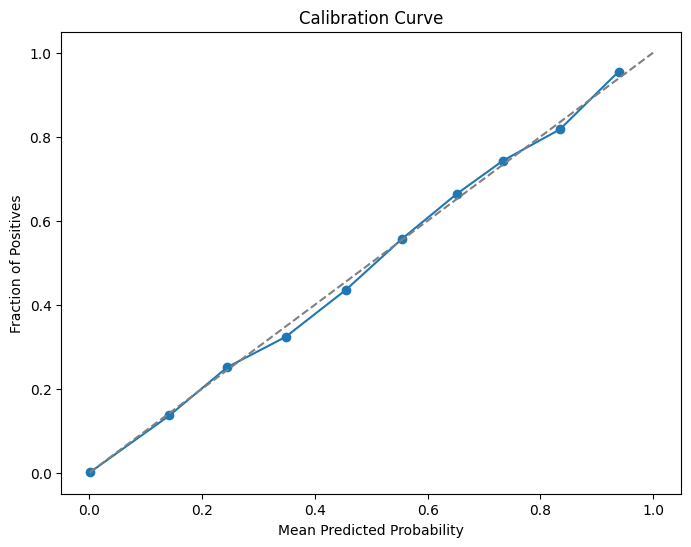

0.014381947507439418


In [247]:
# Adding calib (isotonic)
# Logloss: 0.02385418586559387
# Logloss: imputed
# 0.02372888852503455
# Logloss: imputed and removed a few unnecessary variables
# 0.023720691340422
# Logloss: imouted and added monthly payment
# 0.02294559159914238
predicted_probs = 'LOGISTIC_REG'
training_data['LOGISTIC_REG_CUMM'] = 0
iterations = 1
for i in range(iterations):
    probs,_ = train_and_predict_two_halves(
        training_data, 
        X_columns, 
        'TARGET_EVENT_BINARY',
        model=LogisticRegression(max_iter=400, random_state=42,solver='lbfgs'),
        augment_distribution=True,
        augment_distribution_percentage=1.48,
        calibrate=True,
        unique_loans=False,
        should_smote=False,
        maximal_sample=False,
        random_sample=i,
        calib_method='isotonic',
        show_curve=(i==0),
    )
    training_data[predicted_probs] = probs
    training_data['LOGISTIC_REG_CUMM'] += probs
training_data['LOGISTIC_REG_CUMM'] /= iterations
print(probs.mean())
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'LOGISTIC_REG'] = 0
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'LOGISTIC_REG_CUMM'] = 0

In [248]:
new_proba = scale_yearly_proba(training_data, 'LOGISTIC_REG')
print(new_proba.mean())
training_data['YEAR_SCALED_PROBA'] = new_proba
submission = create_submission_file(training_data, 'YEAR_SCALED_PROBA', data_submission_example, filename='./predictions/lr.csv')

0.011528395520289688
Logloss:
0.26222557117071554
Before centering:
0.999999981237801 6.476341664840568e-06 0.01508569204623995
Centering probabilities...
0.0002856920462399465 2.001
0.0002808317859532162 2.002
0.0002759748635556003 2.0029999999999997
0.00027112127534390483 2.0039999999999996
0.00026627101762081475 2.0049999999999994
0.0002614240866949183 2.0059999999999993
0.00025658047888064625 2.0069999999999992
0.000251740190498409 2.007999999999999
0.0002469032178743849 2.008999999999999
0.00024206955734063992 2.009999999999999
0.00023723920523502882 2.010999999999999
0.00023241215790125933 2.0119999999999987
0.00022758841168890598 2.0129999999999986
0.000222767962953202 2.0139999999999985
0.00021795080805533766 2.0149999999999983
0.00021313694336211157 2.0159999999999982
0.00020832636524620654 2.016999999999998
0.00020351907008595363 2.017999999999998
0.00019871505426555768 2.018999999999998
0.00019391431417480932 2.019999999999998
0.00018911684620928106 2.0209999999999977
0.0001

Mean in year 0.011345816067598232
5206
2769.8234336859236
Logloss:
0.017953049723997572
ROC AUC Score: 0.9965680312982493


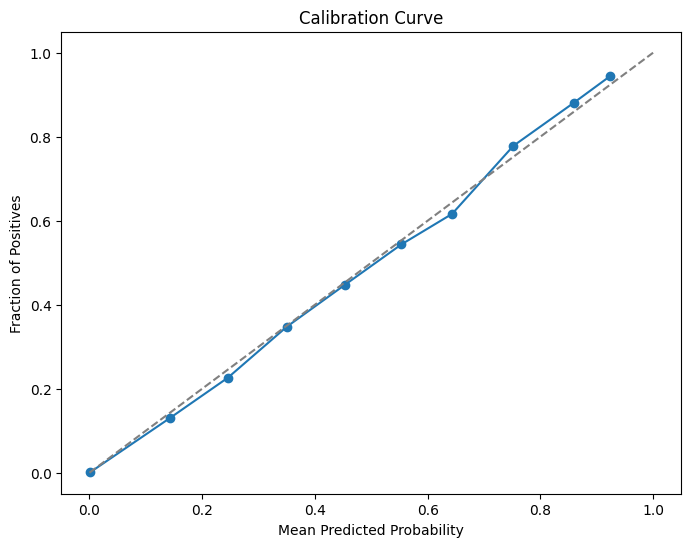

0.012850322991623314


In [249]:
predicted_probs = 'XGB'
training_data['XGB_CUMM'] = 0
iterations = 1
for i in range(iterations):
    probs,_ = train_and_predict_two_halves(
        training_data, 
        X_columns, 
        'TARGET_EVENT_BINARY',
        model=xgb.XGBClassifier(max_depth=2, n_estimators=70, random_state=42, use_label_encoder=False, eval_metric='logloss'),
        augment_distribution=True,
        augment_distribution_percentage=1.68,
        calibrate=True,
        random_sample=i,
        calib_method='isotonic',
        show_curve=(i==0),
    )
    training_data[predicted_probs] = probs
    training_data['XGB_CUMM'] += probs
training_data['XGB_CUMM'] /= iterations
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'XGB'] = 0
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'XGB_CUMM'] = 0

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# # 100 minleaf 0.1 lr maxdepth 4 n_est 100 ll: 0.0157 tll: 0.0252 (25, 25, 50)

# predicted_probs = 'GBM'
# training_data['GBM_CUMM'] = 0
# iterations = 1
# for i in range(iterations):
#     probs,_ = train_and_predict_two_halves(
#         training_data, 
#         X_columns, 
#         'TARGET_EVENT_BINARY',
#         model=GradientBoostingClassifier(min_samples_leaf=100,learning_rate=0.1,max_depth=3, n_estimators=200, random_state=42,),
#         augment_distribution=True,
#         augment_distribution_percentage=1.68,
#         calibrate=True,
#         random_sample=i,
#     )
#     training_data[predicted_probs] = probs
#     training_data['GBM_CUMM'] += probs
# training_data['GBM_CUMM'] /= iterations
# print(probs.mean())
# # this helps
# training_data.loc[training_data['TARGET_EVENT'] == 'E', 'GBM'] = 0
# training_data.loc[training_data['TARGET_EVENT'] == 'E', 'GBM_CUMM'] = 0

Mean in year 0.011345816067598232
5206
2259.690510058932
Logloss:
0.018610920572481742
ROC AUC Score: 0.9963067312297933


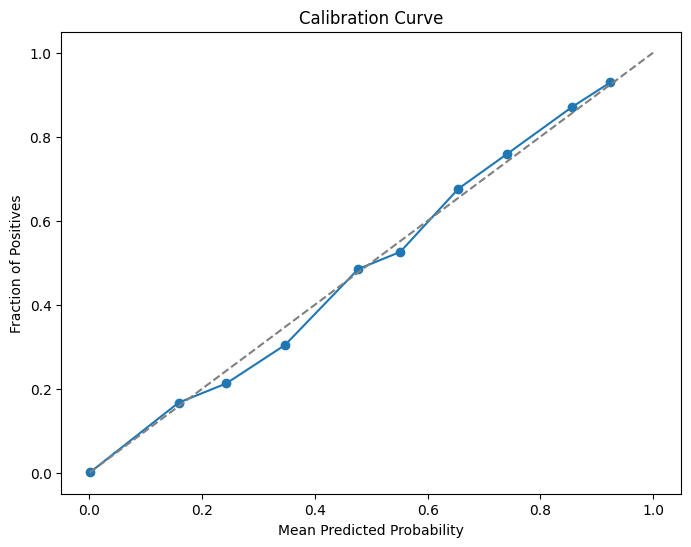

0.012775085662364148


In [250]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

# Logloss:
# 0.02484109588442129 RF 200-3
# Logloss:
# 0.023534501248296504 RF 200-4-10
# Logloss:
# 0.02304888836026815 400-4- log_loss 25 
# Logloss:
# 0.0216212401349101 400-5- log_loss 25
# Logloss:
# 0.020320409332841818 400-6- log_loss 25
# Logloss:
# 0.018208761775049223 400-8- log_loss 30
# Logloss:
# 0.019426191288290054 200-8- log_loss 100
# Logloss:
# 0.01860565128621486 400 10 Logloss 100
# Logloss:
# 0.018445624629156568 400 11 Logloss 100

# Logloss: with 600:{"Logloss": 0.024925861276495972, "ROCAUC": 0.9808195618274818}
# 0.01839314824358871
# Logloss: with 1200 40 min {"Logloss": 0.024940499198232467, "ROCAUC": 0.9807876124372913}
# 0.01838510029059968
# Logloss: current
# 0.018835162103137956
predicted_probs = 'NN'
training_data['RF_CUMM'] = 0
iterations = 1
for i in range(iterations):
    probs,_ = train_and_predict_two_halves(
        training_data, 
        X_columns, 
        'TARGET_EVENT_BINARY',
        model= RandomForestClassifier(n_estimators=600, max_depth=11, random_state=42, min_samples_leaf=100, criterion="log_loss", n_jobs=-1   ),
        augment_distribution=True,
        augment_distribution_percentage=1.58,
        calibrate=True,
        random_sample=i,
        calib_method='isotonic',
        show_curve=(i==0),
    )
    training_data[predicted_probs] = probs
    training_data['RF_CUMM'] += probs
training_data['RF_CUMM'] /= iterations
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'NN'] = 0
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'RF_CUMM'] = 0

In [ ]:
# from lightgbm import LGBMClassifier

# predicted_probs = 'LGBM'
# probs,_ = train_and_predict_two_halves(
#     training_data, 
#     X_columns, 
#     'TARGET_EVENT_BINARY',
#     model= LGBMClassifier(n_estimators=100, max_depth=3,boosting_type="dart", random_state=42),
#     augment_distribution=True,
#     augment_distribution_percentage=1.48,
#     calibrate=True,
# )
# training_data[predicted_probs] = probs
# print(probs.mean())
# # this helps
# training_data.loc[training_data['TARGET_EVENT'] == 'E', 'LGBM'] = 0

In [251]:
print(f"Logreg : { log_loss(training_data['TARGET_EVENT_BINARY'], training_data['LOGISTIC_REG'])}")
# print(f"XGB+ : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['ENSEMBLE'])}")
# print(f"RF+ : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['ENSEMBLE_NN'])}")
print(f"XGB : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['XGB'])}")
print(f"RF : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['NN'])}")
# print(f"LGBM : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['LGBM'])}")

Logreg : 0.020912857973395493
XGB : 0.016528951649576417
RF : 0.016496573309791734


In [256]:
values = [30, 50, 20]
# [0.25 0.25 0.25 0.25]
# CUSTOM+ : 0.01588790730454689 og
# CUSTOM+ : 0.016648811980442747
# [25, 30,45]: CUSTOM+ : 0.016663738940216465

values = values/np.sum(values)
print(values)
custom = training_data['LOGISTIC_REG']*values[0] + training_data['NN']*values[1]+training_data['XGB']*values[2]

print(f"CUSTOM+ : {log_loss(training_data['TARGET_EVENT_BINARY'], custom)}")

[0.3 0.5 0.2]
CUSTOM+ : 0.01680287755461947


In [257]:
training_data['CUSTOM'] = custom
new_proba = scale_yearly_proba(training_data, 'CUSTOM', targets =[ 0.0052, 0.0100, 0.0185], logging=True)
training_data['CUSTOM'] = new_proba

Before scaling:
0.006219150394537529 0.007902335453474246 0.012284581303641172
0.013123417191744868
Adter scaling:
0.00479465430057086 0.011239993643594307 0.021802883213675586
0.012948459236347644
Adter scaling:
0.004808391720136475 0.011180036190490556 0.021659902706742156
0.012881980321499249
Adter scaling:
0.004822208606349067 0.011120752810821706 0.021519142472125195
0.012816539678937687
Adter scaling:
0.004836105657113741 0.011062131360905354 0.02138054011788184
0.012752111265268335
Adter scaling:
0.0048500835786309164 0.011004160008904291 0.02124403589682799
0.012688670086181868
Adter scaling:
0.004864143085521741 0.010946827224253157 0.021109572559028875
0.012626192140360273
Adter scaling:
0.004878284900956006 0.01089012176753157 0.02097709521428646
0.012564654367099066
Adter scaling:
0.004892509756782212 0.010834032680760997 0.020846551203834687
0.012504034597356922
Adter scaling:
0.004906818393660089 0.010778549278104465 0.020717889980523804
0.012444311507968693
Adter scaling

In [258]:
submission = create_submission_file(training_data, 'CUSTOM', data_submission_example, filename='./predictions/nn-xgb-log-custom.csv')

Logloss:
0.2643359588423281
Before centering:
0.999999999999924 2.220457275381449e-06 0.014738654416761558
Centering probabilities...
-6.134558323843929e-05 1.999
-5.6954335546022944e-05 1.9980000000000002
-5.25601451495418e-05 1.9970000000000003
-4.816300874556888e-05 1.9960000000000004
-4.3762923025266603e-05 1.9950000000000006
-3.935988467442149e-05 1.9940000000000007
-3.4953890373392096e-05 1.9930000000000008
-3.054493679706741e-05 1.9920000000000009
-2.613302061498131e-05 1.991000000000001
-2.1718138491199843e-05 1.990000000000001
-1.7300287084283036e-05 1.9890000000000012
-1.2879463047364703e-05 1.9880000000000013
-8.455663028081317e-06 1.9870000000000014
0.9999999999999366 2.2338604230842662e-06 0.01479154433697192
Saved file: ./predictions/nn-xgb-log-custom.csv


In [238]:
submission.isna().sum()

BORROWER_ID    0
PRED           0
dtype: int64

In [230]:
print(f"Logreg : { log_loss(training_data['TARGET_EVENT_BINARY'], training_data['LOGISTIC_REG_CUMM'])}")
print(f"XGB : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['XGB_CUMM'])}")
print(f"RF : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['RF_CUMM'])}")

Logreg : 0.020134263366506807
XGB : 0.01771778774236349
RF : 0.01637282709272169


In [231]:
values = [25, 25,50]
values = values/np.sum(values)
print(values)
custom = training_data['LOGISTIC_REG_CUMM']*values[0] + training_data['XGB_CUMM']*values[1]+ training_data['RF_CUMM']*values[2]

print(f"CUSTOM+ : {log_loss(training_data['TARGET_EVENT_BINARY'], custom)}")
training_data['CUSTOM'] = custom
new_proba = scale_yearly_proba(training_data, 'CUSTOM', targets =[ 0.0053, 0.0101, 0.0185])
training_data['CUSTOM'] = new_proba

[0.25 0.25 0.5 ]
CUSTOM+ : 0.016533410454972034


In [232]:
submission = create_submission_file(training_data, 'CUSTOM', data_submission_example, filename='./predictions/nn-xgb-log-custom-cumm.csv')

Logloss:
0.2675654201754927
Before centering:
1.0000130795158815 3.6340871196749447e-06 0.01470103385508877
Centering probabilities...
nan 1.999
0.9999999999999828 3.6340871196749447e-06 0.014700152280562354
Saved file: ./predictions/nn-xgb-log-custom-cumm.csv


Mean in year 0.011345816067598232
5206
1750.5931790499392
[LightGBM] [Info] Number of positive: 5932, number of negative: 394910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 400842, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014799 -> initscore=-4.198296
[LightGBM] [Info] Start training from score -4.198296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5932, number of negative: 394910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

In [42]:
new_proba = scale_yearly_proba(training_data, 'ENSEMBLE_LGBM')
print(new_proba.mean())
training_data['NN_LOG_XGB_LGBM'] = new_proba

0.011387661618943183


In [43]:
# Logloss:
# 0.2627792536515289: 
submission = create_submission_file(training_data, 'NN_LOG_XGB_LGBM', data_submission_example, filename='./predictions/nn-xgb-log-lgbm.csv')

Logloss:
0.26410894477695007
Before centering:
0.9999999999999206 2.404636646247127e-06 0.014602542785973009
Centering probabilities...
-0.00019745721402699215 1.999
-0.00019307935449725672 1.9980000000000002
-0.00018869853882500995 1.9970000000000003
-0.00018431476366658102 1.9960000000000004
-0.00017992802567283646 1.9950000000000006
-0.0001755383214891021 1.9940000000000007
-0.00017114564775523762 1.9930000000000008
-0.00016675000110553083 1.9920000000000009
-0.00016235137816872185 1.991000000000001
-0.00015794977556803265 1.990000000000001
-0.00015354518992110114 1.9890000000000012
-0.0001491376178399586 1.9880000000000013
-0.00014472705593112332 1.9870000000000014
-0.00014031350079539429 1.9860000000000015
-0.00013589694902806267 1.9850000000000017
-0.00013147739721871762 1.9840000000000018
-0.00012705484195137812 1.9830000000000019
-0.00012262927980433158 1.982000000000002
-0.00011820070735028658 1.981000000000002
-0.00011376912115618372 1.9800000000000022
-0.00010933451778334137

In [44]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
# Logloss:
# 0.01727067871139171

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=11, random_state=42, min_samples_leaf=100, criterion="log_loss", n_jobs=-1   )),
    ('lgb', LGBMClassifier(n_estimators=60, max_depth=4,boosting_type="dart", random_state=42)),
    ('xgb', xgb.XGBClassifier(max_depth=2, n_estimators=70, random_state=42, use_label_encoder=False, eval_metric='logloss'))
]
meta_model = LogisticRegression()
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

predicted_probs = 'STACKED'
probs, trained_model = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model= stacked_model,
    augment_distribution=True,
    augment_distribution_percentage=1.48,
    calibrate=True,
)
training_data[predicted_probs] = probs
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'STACKED'] = 0

# training_data['ENSEMBLE_STACKED'] = 0.9*training_data['ENSEMBLE_NN']+ 0.1*training_data['STACKED']

Mean in year 0.011345816067598232
5206
1750.5931790499392
[LightGBM] [Info] Number of positive: 5932, number of negative: 394910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 400842, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014799 -> initscore=-4.198296
[LightGBM] [Info] Start training from score -4.198296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4745, number of negative: 315928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

In [45]:
training_data['ENSEMBLE_STACKED'] = 0.5*training_data['LOGISTIC_REG']+ 0.5*training_data['STACKED']

In [46]:
new_proba = scale_yearly_proba(training_data, 'ENSEMBLE_STACKED')
print(new_proba.mean())
training_data['ENSEMBLE_STACKED_SCALED'] = new_proba

0.011389968960770625


In [47]:
submission = create_submission_file(training_data, 'ENSEMBLE_STACKED_SCALED', data_submission_example, filename='./predictions/stacked-nn-xgb-log-lgbm.csv')

Logloss:
0.26356365759030304
Before centering:
0.9999999999993184 3.5809547743737014e-06 0.014705217226777713
Centering probabilities...
-9.47827732222916e-05 1.999
-9.029485818285408e-05 1.9980000000000002
-8.580389676962619e-05 1.9970000000000003
-8.130988554106225e-05 1.9960000000000004
-7.68128210499458e-05 1.9950000000000006
-7.23126998434017e-05 1.9940000000000007
-6.780951846291003e-05 1.9930000000000008
-6.330327344424187e-05 1.9920000000000009
-5.879396131748711e-05 1.991000000000001
-5.4281578607054404e-05 1.990000000000001
-4.976612183158098e-05 1.9890000000000012
-4.5247587504062756e-05 1.9880000000000013
-4.072597213164095e-05 1.9870000000000014
-3.6201272215749536e-05 1.9860000000000015
-3.167348425213434e-05 1.9850000000000017
-2.7142604730655273e-05 1.9840000000000018
-2.2608630135407745e-05 1.9830000000000019
-1.8071556944701875e-05 1.982000000000002
-1.3531381631010433e-05 1.981000000000002
-8.988100660989665e-06 1.9800000000000022
0.999999999999479 3.615300063430915e

In [48]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
# Logloss:
# 0.01727067871139171
model
base_models = [
    ('lr', CalibratedClassifierCV(base_estimator=LogisticRegression(max_iter=400, random_state=42,solver='lbfgs'), method='isotonic', )),
    ('rf', CalibratedClassifierCV(base_estimator= RandomForestClassifier(n_estimators=100, max_depth=11, random_state=42, min_samples_leaf=100, criterion="log_loss", n_jobs=-1   ), method='isotonic', )),
    ('lgb', CalibratedClassifierCV(base_estimator= LGBMClassifier(n_estimators=60, max_depth=4,boosting_type="dart", random_state=42), method='isotonic', )),
    ('xgb', CalibratedClassifierCV(base_estimator= xgb.XGBClassifier(max_depth=2, n_estimators=70, random_state=42, use_label_encoder=False, eval_metric='logloss'), method='isotonic', ))
]
meta_model = LogisticRegression()
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

predicted_probs = 'STACKED'
probs,trained_model_2 = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model= stacked_model,
    augment_distribution=True,
    augment_distribution_percentage=1.48,
    calibrate=True,
)
training_data[predicted_probs] = probs
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'STACKED'] = 0

# training_data['ENSEMBLE_STACKED'] = 0.9*training_data['ENSEMBLE_NN']+ 0.1*training_data['STACKED']

Mean in year 0.011345816067598232
5206
1750.5931790499392
[LightGBM] [Info] Number of positive: 4745, number of negative: 315928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4098
[LightGBM] [Info] Number of data points in the train set: 320673, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014797 -> initscore=-4.198423
[LightGBM] [Info] Start training from score -4.198423
[LightGBM] [Info] Number of positive: 4745, number of negative: 315928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4095
[LightGBM] [Info] Number of data points in the train

In [68]:
training_data['ENSEMBLE_STACKED'] =0.5*training_data['ENSEMBLE_NN']+0.5* training_data['STACKED']
new_proba = scale_yearly_proba(training_data, 'ENSEMBLE_STACKED')
print(new_proba.mean())
training_data['ENSEMBLE_STACKED_SCALED'] = new_proba
submission = create_submission_file(training_data, 'ENSEMBLE_STACKED_SCALED', data_submission_example, filename='./predictions/stacked-nn-xgb-log-lgbm-v2.csv')

0.011369975080190843
Logloss:
0.2670883780636673
Before centering:
1.0 2.8514065779416953e-05 0.01450183927509637
Centering probabilities...
-0.0002981607249036289 1.999
-0.0002941216245565814 1.9980000000000002
-0.000290079834252565 1.9970000000000003
-0.0002860353509213133 1.9960000000000004
-0.0002819881714875433 1.9950000000000006
-0.000277938292870851 1.9940000000000007
-0.0002738857119857271 1.9930000000000008
-0.0002698304257416021 1.9920000000000009
-0.0002657724310427545 1.991000000000001
-0.00026171172478834694 1.990000000000001
-0.0002576483038724299 1.9890000000000012
-0.0002535821651838792 1.9880000000000013
-0.0002495133056063959 1.9870000000000014
-0.00024544172201856375 1.9860000000000015
-0.00024136741129374487 1.9850000000000017
-0.00023729037030010072 1.9840000000000018
-0.00023321059590063198 1.9830000000000019
-0.00022912808495307094 1.982000000000002
-0.00022504283430997522 1.981000000000002
-0.00022095484081863584 1.9800000000000022
-0.0002168641013210841 1.97900

In [63]:
trained_model_2.base_estimator.final_estimator.get_params

()

In [66]:
trained_model.final_estimator

AttributeError: 'CalibratedClassifierCV' object has no attribute 'final_estimator'

In [51]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis



predicted_probs = 'QDA'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model= QuadraticDiscriminantAnalysis(),
    augment_distribution=True,
    augment_distribution_percentage=1.48,
    calibrate=True,
)
training_data[predicted_probs] = probs
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'QDA'] = 0

training_data['ENSEMBLE_QDA'] = 0.9*training_data['ENSEMBLE_NN']+ 0.1*training_data['QDA']

Mean in year 0.011345816067598232
5206
1750.5931790499392
Logloss:
0.03345960035278355
ROC AUC Score: 0.9690328434892286
0.019327983772770608


In [74]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

# Logloss:
# 0.025080414519332874 1% & 10 estimators
predicted_probs = 'SVC'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model= BaggingClassifier(SVC(kernel='rbf', probability=True), max_samples=2000, n_estimators=100, n_jobs=-1, random_state=42),
    augment_distribution=True,
    augment_distribution_percentage=1.48,
    calibrate=True,
)
training_data[predicted_probs] = probs
print(probs.mean())
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'SVC'] = 0
training_data['ENSEMBLE_SVC'] = 0.9*training_data['ENSEMBLE_LGBM']+ 0.1*training_data['SVC']

Mean in year 0.011345816067598232
5206
1750.5931790499392
Logloss:
0.029537779758320133


MemoryError: Unable to allocate 880. MiB for an array with shape (1601663, 72) and data type float64

In [ ]:
new_proba = scale_yearly_proba(training_data, 'ENSEMBLE_SVC')
print(new_proba.mean())
training_data['NN_LOG_XGB_LGBM_SVC'] = new_proba

In [ ]:
# Logloss:
# 0.2627792536515289: 
submission = create_submission_file(training_data, 'NN_LOG_XGB_LGBM_SVC', data_submission_example, filename='./predictions/nn-xgb-log-lgbm-svc.csv')

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import numpy as np

# Other necessary imports, like pandas, if you're using a DataFrame

def train_and_evaluate(df, variables, target, model=LogisticRegression(), scaler=StandardScaler(), cv_folds=5, augment_distribution=False):
    # Your lognormal_variables transformation code remains the same
    if lognormal_variables is not None:
        df = df.copy()
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    # Split the data before the given date for training 
    if augment_distribution:
        df_filtered = default_percentage_generator_2016(df, 1.48/100, target)
    else:
        df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    X_filtered = df_filtered[variables]
    y_filtered = df_filtered[target]
    
    # Scale the filtered features
    X_filtered_scaled = scaler.fit_transform(X_filtered)
    
    # Perform cross-validation and fit the model
    cv_scores = cross_val_score(model, X_filtered_scaled, y_filtered, cv=cv_folds, scoring='neg_log_loss')
    
    print(f"CV Log Loss Scores: {-cv_scores}")
    print(f"Mean CV Log Loss: {-np.mean(cv_scores)}")
    
    # Now fit the model to the entire dataset
    model.fit(X_filtered_scaled, y_filtered)
    
    # Scale the entire dataset to predict probabilities for all records
    X_scaled = scaler.transform(df[variables])
    
    # Predict probabilities using the trained model
    proba = model.predict_proba(X_scaled)[:, 1]

    print("Logloss:")
    print(log_loss(y_filtered, model.predict_proba(X_filtered_scaled)))
    # Calculate log loss on the full dataset
    full_log_loss = log_loss(df[target], proba)

    print(f"Full Dataset Log Loss: {full_log_loss}")

    return proba, cv_scores, full_log_loss

# You might call the function like this
# probabilities, cv_scores, full_log_loss = train_and_evaluate(df, variables, target)



In [ ]:
# Logloss xgb :
# 0.016317211616370328
# Logloss logistic regression:
# 0.02385418586559387
predicted_probs = 'XGBOOST'
probs, _, _ = train_and_evaluate(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model=xgb.XGBClassifier(max_depth=3, reg_lambda=1, n_estimators=60, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    augment_distribution=True
)
training_data[predicted_probs] = probs
print(probs.mean())


In [ ]:
probs.std()

In [ ]:
magic_number = 1.6
experiment_probs = calculate_probabilities(training_data, 'XGBOOST', magic_number)
print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())


In [ ]:
training_data['EXPERIMENT_PROBS_XGB'] = experiment_probs
submission_exp = create_submission_file(training_data, 'EXPERIMENT_PROBS_XGB', data_submission_example, filename='./predictions/xgb-prediction-with-time-param-0-585.csv')

In [ ]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
sns.kdeplot(submission, label='Submission OG', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='PredictionOG', lw=3, alpha=1)
sns.kdeplot(experiment_probs, label='Fine tuned solution', lw=3, alpha=1)
sns.kdeplot(submission_exp, label='Fine tuned solution per borrower', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [ ]:
condition = (submission_exp['PRED'] > 0.9999)# | (submission_exp['PRED'] < 0.01)
ensemble_submission = submission.copy()
ensemble_submission.loc[condition,'PRED'] = submission_exp.loc[condition,'PRED']

In [ ]:
condition.sum()

In [ ]:
ensemble_submission['PRED'].mean()  

In [ ]:
calculate_probabilities_vec(ensemble_submission['PRED'].values, 2.029).mean()

In [ ]:
ensemble_submission['PRED'] = calculate_probabilities_vec(ensemble_submission['PRED'].values, 2.029)

In [ ]:
ensemble_submission.to_csv('./predictions/ensemble-submission.csv', index=False)

In [ ]:
ensemble_submission.head(5)

In [ ]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
sns.kdeplot(submission, label='Submission OG', lw=3, alpha=1, color='r')
# sns.kdeplot(training_data['LOGISTIC_REG'], label='PredictionOG', lw=3, alpha=1)
sns.kdeplot(ensemble_submission, label='Fine tuned solution', lw=3, alpha=1, color='g')
# sns.kdeplot(submission_exp, label='Fine tuned solution per borrower', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()